## Load Data

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10


# Change the images to grayscale
# Convert to a tensor
image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Download the base dataset files
train_dataset = CIFAR10("~/data/CIFAR10", train=True, download=True, transform=image_transforms) # 50000 training images
test_dataset = CIFAR10("~/data/CIFAR10", train=False, download=True, transform=image_transforms) # 10000 test images

# Split the training dataset to separate a validation set
train_dataset_percent = 0.8
train_dataset_size = int(train_dataset_percent * len(train_dataset))
validation_dataset_size = len(train_dataset) - train_dataset_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_dataset_size, validation_dataset_size])

# Get one image sample so that we can look at the shape
image, label = train_dataset[0]

print("Image Size: {}".format(image.shape))
print()
print("Training Set:   {} samples".format(len(train_dataset)))
print("Validation Set: {} samples".format(len(validation_dataset)))
print("Test Set:       {} samples".format(len(test_dataset)))

Files already downloaded and verified
Files already downloaded and verified
Image Size: torch.Size([1, 32, 32])

Training Set:   40000 samples
Validation Set: 10000 samples
Test Set:       10000 samples


## Setup Training Variables
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [3]:
num_epochs = 80
batch_size = 512

## Create Dataloaders
Dataloaders allow us to easily and efficiently load batches for training and testing.

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders = {
    'train': train_loader,
    'val': validation_loader,
    'test': test_loader
}

## Visualize Data

View a sample from the dataset and dataloaders.

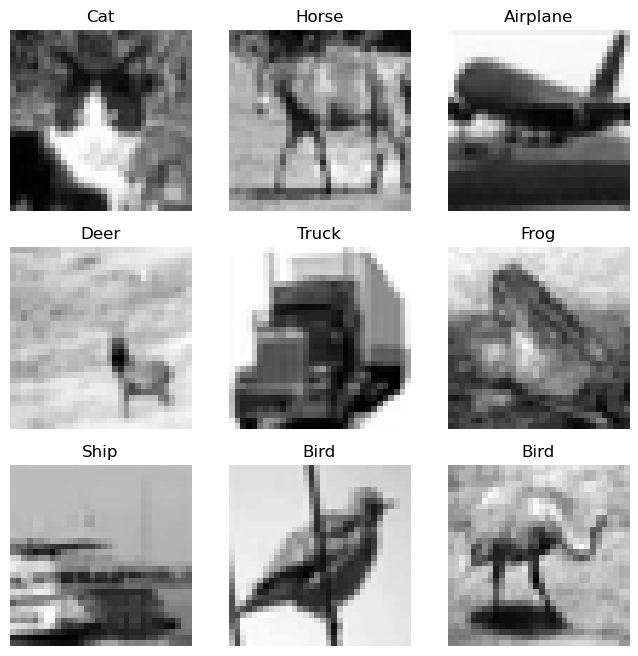

In [5]:
import torchvision.utils
import matplotlib.pyplot as plt
%matplotlib inline

# images, labels = next(iter(dataloaders['train']))

# fig = plt.figure(figsize=(16, 8))
# out = torchvision.utils.make_grid(images, nrow=16)

# plt.imshow(out.permute(1, 2, 0), cmap="gray")

labels_map = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Implement CNN

### Input
Accepts a 32x32xC image as input, where C is the number of color channels. If images are grayscale, C is 1.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `torch.flatten`.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

    # Layer 2: Convolutional. Input = 14x14x6 Output = 10x10x16.
    self.conv2 = nn.Conv2d(6, 16, 5)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    self.fc1 =  nn.Linear(400, 120)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    self.fc2 = nn.Linear(120, 84)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # Layer 1
    x = self.conv1(x)
    # Activation
    x = F.relu(x)
    # Pooling
    x = F.max_pool2d(x, 2)
    # Layer 2
    x = self.conv2(x)
    # Activation
    x = F.relu(x)
    # Pooling
    x = F.max_pool2d(x, 2)
    # Flatten
    x = torch.flatten(x, 1)
    # Layer 3
    x = self.fc1(x)
    # Activation
    x = F.relu(x)
    # Layer 4
    x = self.fc2(x)
    # Activation
    x = F.relu(x)
    # Layer 5
    x = self.fc3(x)

    return x

## Training Setup
This section defines the model and optimizer to use in training. The train_model function comes from the [PyTorch documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [7]:
import time
import copy

model = CNN()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
export_path = "lenet.pt"

# Setup a device for training (use GPU if it's available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
  since = time.time()

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_acc_history.append(epoch_acc)

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model, val_acc_history

## Train the Model

In [8]:
model = model.to(device)
model, _ = train_model(model, dataloaders, criterion, optimizer, num_epochs)
torch.save(model, export_path)

Epoch 0/79
----------
train Loss: 2.3021 Acc: 0.1123
val Loss: 2.3008 Acc: 0.1288

Epoch 1/79
----------
train Loss: 2.2977 Acc: 0.1320
val Loss: 2.2935 Acc: 0.1257

Epoch 2/79
----------
train Loss: 2.2695 Acc: 0.1606
val Loss: 2.2188 Acc: 0.1720

Epoch 3/79
----------
train Loss: 2.1819 Acc: 0.1900
val Loss: 2.1612 Acc: 0.1826

Epoch 4/79
----------
train Loss: 2.1232 Acc: 0.2268
val Loss: 2.1249 Acc: 0.2091

Epoch 5/79
----------
train Loss: 2.0595 Acc: 0.2567
val Loss: 2.0701 Acc: 0.2497

Epoch 6/79
----------
train Loss: 2.0008 Acc: 0.2811
val Loss: 1.9987 Acc: 0.2759

Epoch 7/79
----------
train Loss: 1.9267 Acc: 0.3086
val Loss: 1.9078 Acc: 0.3174

Epoch 8/79
----------
train Loss: 1.8619 Acc: 0.3347
val Loss: 1.8767 Acc: 0.3262

Epoch 9/79
----------
train Loss: 1.8012 Acc: 0.3579
val Loss: 1.8606 Acc: 0.3301

Epoch 10/79
----------
train Loss: 1.7577 Acc: 0.3690
val Loss: 1.7707 Acc: 0.3596

Epoch 11/79
----------
train Loss: 1.7103 Acc: 0.3901
val Loss: 1.7056 Acc: 0.3859

Ep

KeyboardInterrupt: 

## Evaluation Function
This function is deisgned to evaluate the model.

In [ ]:
def evaluate(model, dataloader):
  number_correct_predictions = 0
  number_samples = 0
  with torch.set_grad_enabled(False):
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)
      predicted_logits = model(images)
      predicted_labels = torch.argmax(predicted_logits, dim=1)
      correct_predictions = torch.sum(predicted_labels == labels)
      number_correct_predictions += correct_predictions.item()
      number_samples += len(images)
  return float(number_correct_predictions) / number_samples

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

In [ ]:
# Load the best model
model = torch.load("lenet.pt")
model = model.to(device)
model.eval()
test_accuracy = evaluate(model, dataloaders['test'])
print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.539
